# Détection de fraude par carte de crédit

### Compréhension du Business 

La détection de fraude par carte de crédit est un problème classique de déséquilibre de classe dans lequel le nombre de transactions frauduleuses est bien inférieur au nombre de transactions légitimes. La plupart des approches traditionnelles échouent à cause du surajustement et d'un biais en faveur des transactions légitimes. Nous abordons donc ce problème comme une détection d’anomalies. 
### Questions Clés


1À quelle heure les fraudes par carte de crédit ont-elles généralement lieu ? ?
Quelles sont les tendances générales des montants des transactions frauduleuses ?t ?Comment équilibrer les données pour éviter le surajustement des transactions légitimes ?s ?


In [1]:
# Importation des bibliothèques requises
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from mlxtend.plotting import plot_learning_curves
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

### Compréhension des donnéesNous utilisons l'ensemble de données de Kaggle : <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Lien</a>.

-Caractéristiques : 32 fonctionnalités (V1 à V28), Temps, Montant, et Classe.
-Variable cible : Classe (0 : Transaction légitime, 1 : Transaction frauduleuse).
-Données : Pas de valeurs manquantes, toutes les fonctionnalités sont numériques à l'exception de la variable cible.:auduleuse

In [2]:
# Read Data into a Dataframe
df = pd.read_csv('creditcard.csv')


In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


### Préparation des données
-Les données n'ont pas de valeurs manquantes.
-Standardisation des données numériques après équilibrage de l'ensemble de données.
-Analyse des montants : moyenne de 88,34 et écart type de 250,12.
-Distribution temporelle équitable.ndantes.

In [4]:
# Décrire les données
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
def countplot_data(data, feature):
    '''
        Méthode pour calculer et afficher un diagramme de comptage (count plot) pour une caractéristique donnée dans un DataFrame.
        
        Paramètres:
            data (pd.DataFrame): Le DataFrame d'entrée.
            feature (str): La caractéristique du DataFrame pour laquelle on veut tracer le diagramme de comptage.
    '''
    # Définir la taille de la figure
    plt.figure(figsize=(10,10))
    
    # Créer et afficher le diagramme de comptage pour la caractéristique donnée
    sns.countplot(x=feature, data=data)
    
    # Afficher la figure
    plt.show()

def pairplot_data_grid(data, feature1, feature2, target):
    '''
        Méthode pour construire et afficher un diagramme pairplot (diagramme de paires) de deux caractéristiques données par rapport à une étiquette cible.
        
        Paramètres:
            data (pd.DataFrame): Le DataFrame d'entrée.
            feature1 (str): La première caractéristique pour le pairplot.
            feature2 (str): La deuxième caractéristique pour le pairplot.
            target (str): La cible ou l'étiquette (y).
    '''
    
    # Créer un FacetGrid avec les données, en utilisant la cible pour différencier les couleurs
    sns.FacetGrid(data, hue=target, height=6).map(plt.scatter, feature1, feature2).add_legend()
    
    # Afficher la figure
    plt.show()


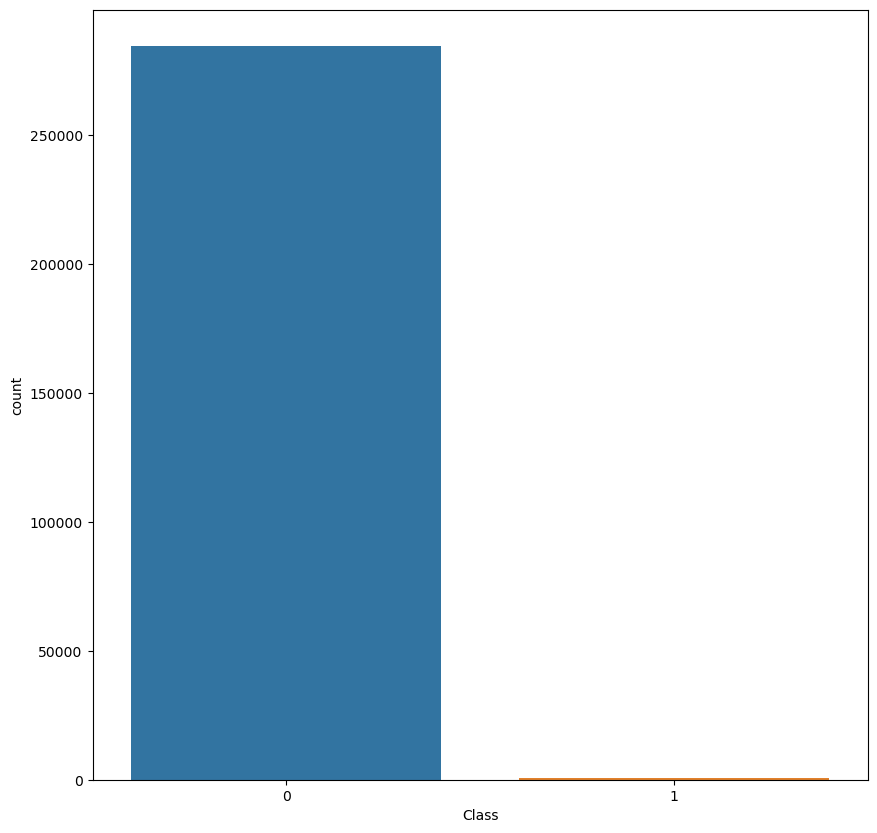

In [8]:
countplot_data(df, df.Class)

### Connaissances:
- L'ensemble de données comporte 32 colonnes avec des caractéristiques inconnues étiquetées V1 à V28, Heure, Montant et Classe.
- La variable cible est « Classe » et le reste des variables sont des fonctionnalités d'entrée
- La Classe a les valeurs suivantes :
    - 0 : Transactions légitimes
    - 1 : Opérations frauduleuses
- L'ensemble de données est très déséquilibré, comme le montre le graphique de comptage avec l'étiquette de classe majoritaire « 0 » et l'étiquette de classe minoritaire « 1 »
- Ainsi, si nous exécutons le modèle sur des données aussi déséquilibrées, nous pourrions finir par le surajuster fortement sur les données et aboutir à un modèle non déployable.
- Par conséquent, nous effectuerons un suréchantillonnage de minorité synthétique sur les données pour les équilibrer, comme indiqué plus tard après avoir exploré d'autres fonctionnalités.

### Quelle est la relation entre les transactions frauduleuses et le montant d’argent ?
Essayons de déterminer la nature des transactions frauduleuses et d'en obtenir un ensemble pertinent par rapport à leur montant.
- Nous émettons l'hypothèse, sur la base de notre nuage de points, que toutes les transactions frauduleuses se produisent pour un montant inférieur à 2 500.

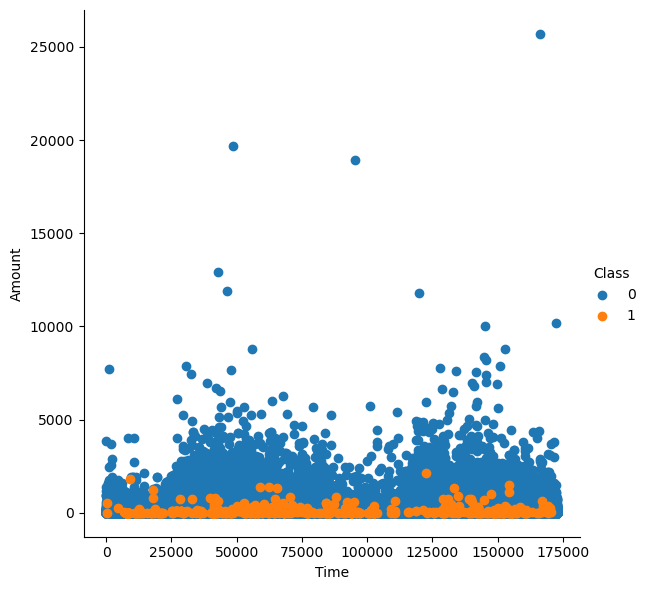

In [9]:
pairplot_data_grid(df, "Time", "Amount", "Class")


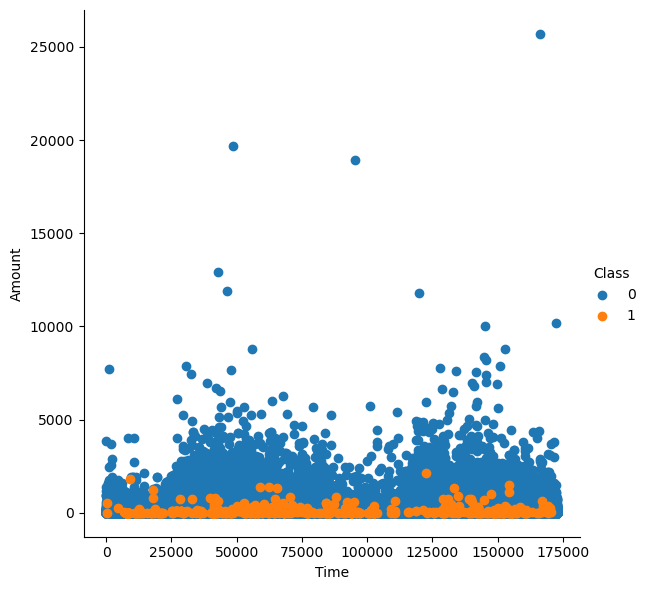

In [10]:
target = "Class"  
pairplot_data_grid(df, "Time", "Amount", target)


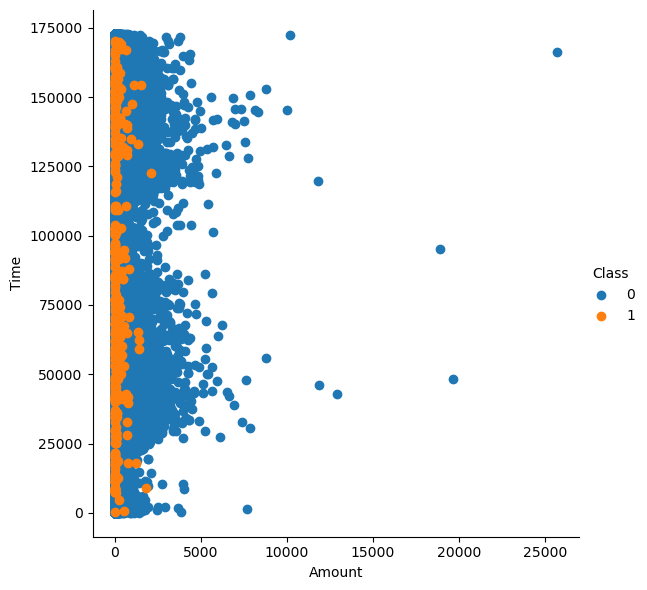

In [11]:
pairplot_data_grid(df, "Amount", "Time", "Class")

### Connaissances:
- On constate que les transactions frauduleuses ne dépassent généralement pas un montant de 2500.
- On peut également observer que les transactions frauduleuses sont uniformément réparties dans le temps.
- Essayons de le prouver

In [12]:
amount_more = 0
amount_less = 0
for i in range(df.shape[0]):
    if df.iloc[i]["Amount"] < 2500:
        amount_less += 1
    else:
        amount_more += 1
print(amount_more)
print(amount_less)
  

449
284358


In [13]:
percentage_less = (amount_less/df.shape[0])*100
percentage_less

99.84234938045763

Ainsi, on observe que 99,85% des transactions s'élèvent à moins de 2500.
Voyons combien d'entre eux sont frauduleux et d'autres légitimes.

In [14]:
fraud = 0
legitimate = 0
for i in range(df.shape[0]):
    if df.iloc[i]["Amount"] < 2500:
        if df.iloc[i]["Class"] == 0:
            legitimate += 1
        else:
            fraud += 1
print("Nombre de fraudes:", fraud)
print("Nombre de transactions légitimes:", legitimate)


Nombre de fraudes: 492
Nombre de transactions légitimes: 283866


In [15]:
# sns.pairplot(df, hue="Class", height=6)
# plt.show()


In [16]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Ainsi, nous pouvons conclure que puisque le nombre de transactions frauduleuses inférieur au montant de 2 500 est le même que le nombre total de transactions frauduleuses. Par conséquent, toutes les transactions frauduleuses sont inférieures à 2 500.

### Quelle est la relation entre le temps et les transactions ?

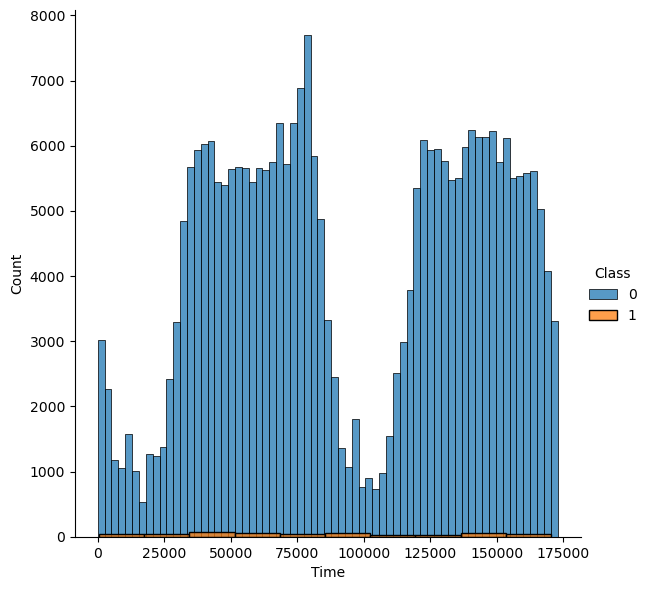

In [17]:
sns.FacetGrid(df, hue="Class", height=6).map(sns.histplot, "Time").add_legend()
plt.show()

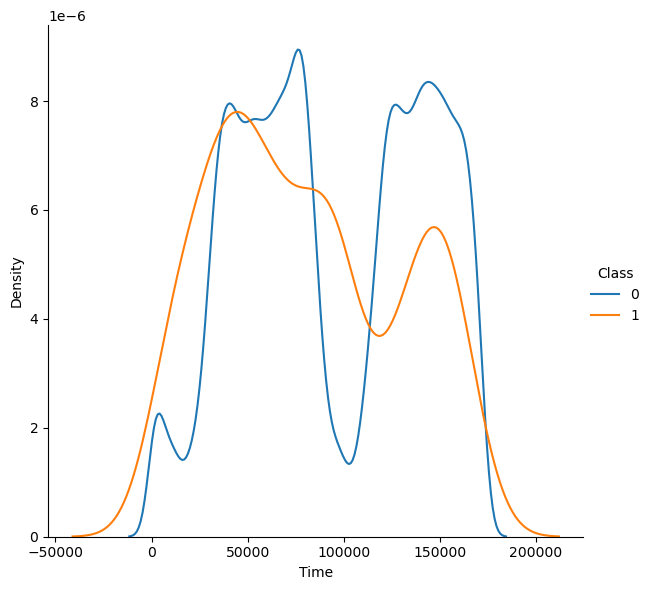

In [18]:
sns.FacetGrid(df, hue="Class", height=6).map(sns.kdeplot, "Time").add_legend()
plt.show()

D'après le diagramme de répartition ci-dessus, il est clair que les transactions frauduleuses sont réparties sur toute la période.

### Méthodologie de Modélisation

-Étudier les corrélations entre fonctionnalités.
-Tracer une carte thermique des corrélations.
-Exécuter GridSearch pour optimiser les classificateurs.
-Créer des pipelines pour l'évaluation.ation

Text(0.5, 1.0, 'Matrice de Corrélation')

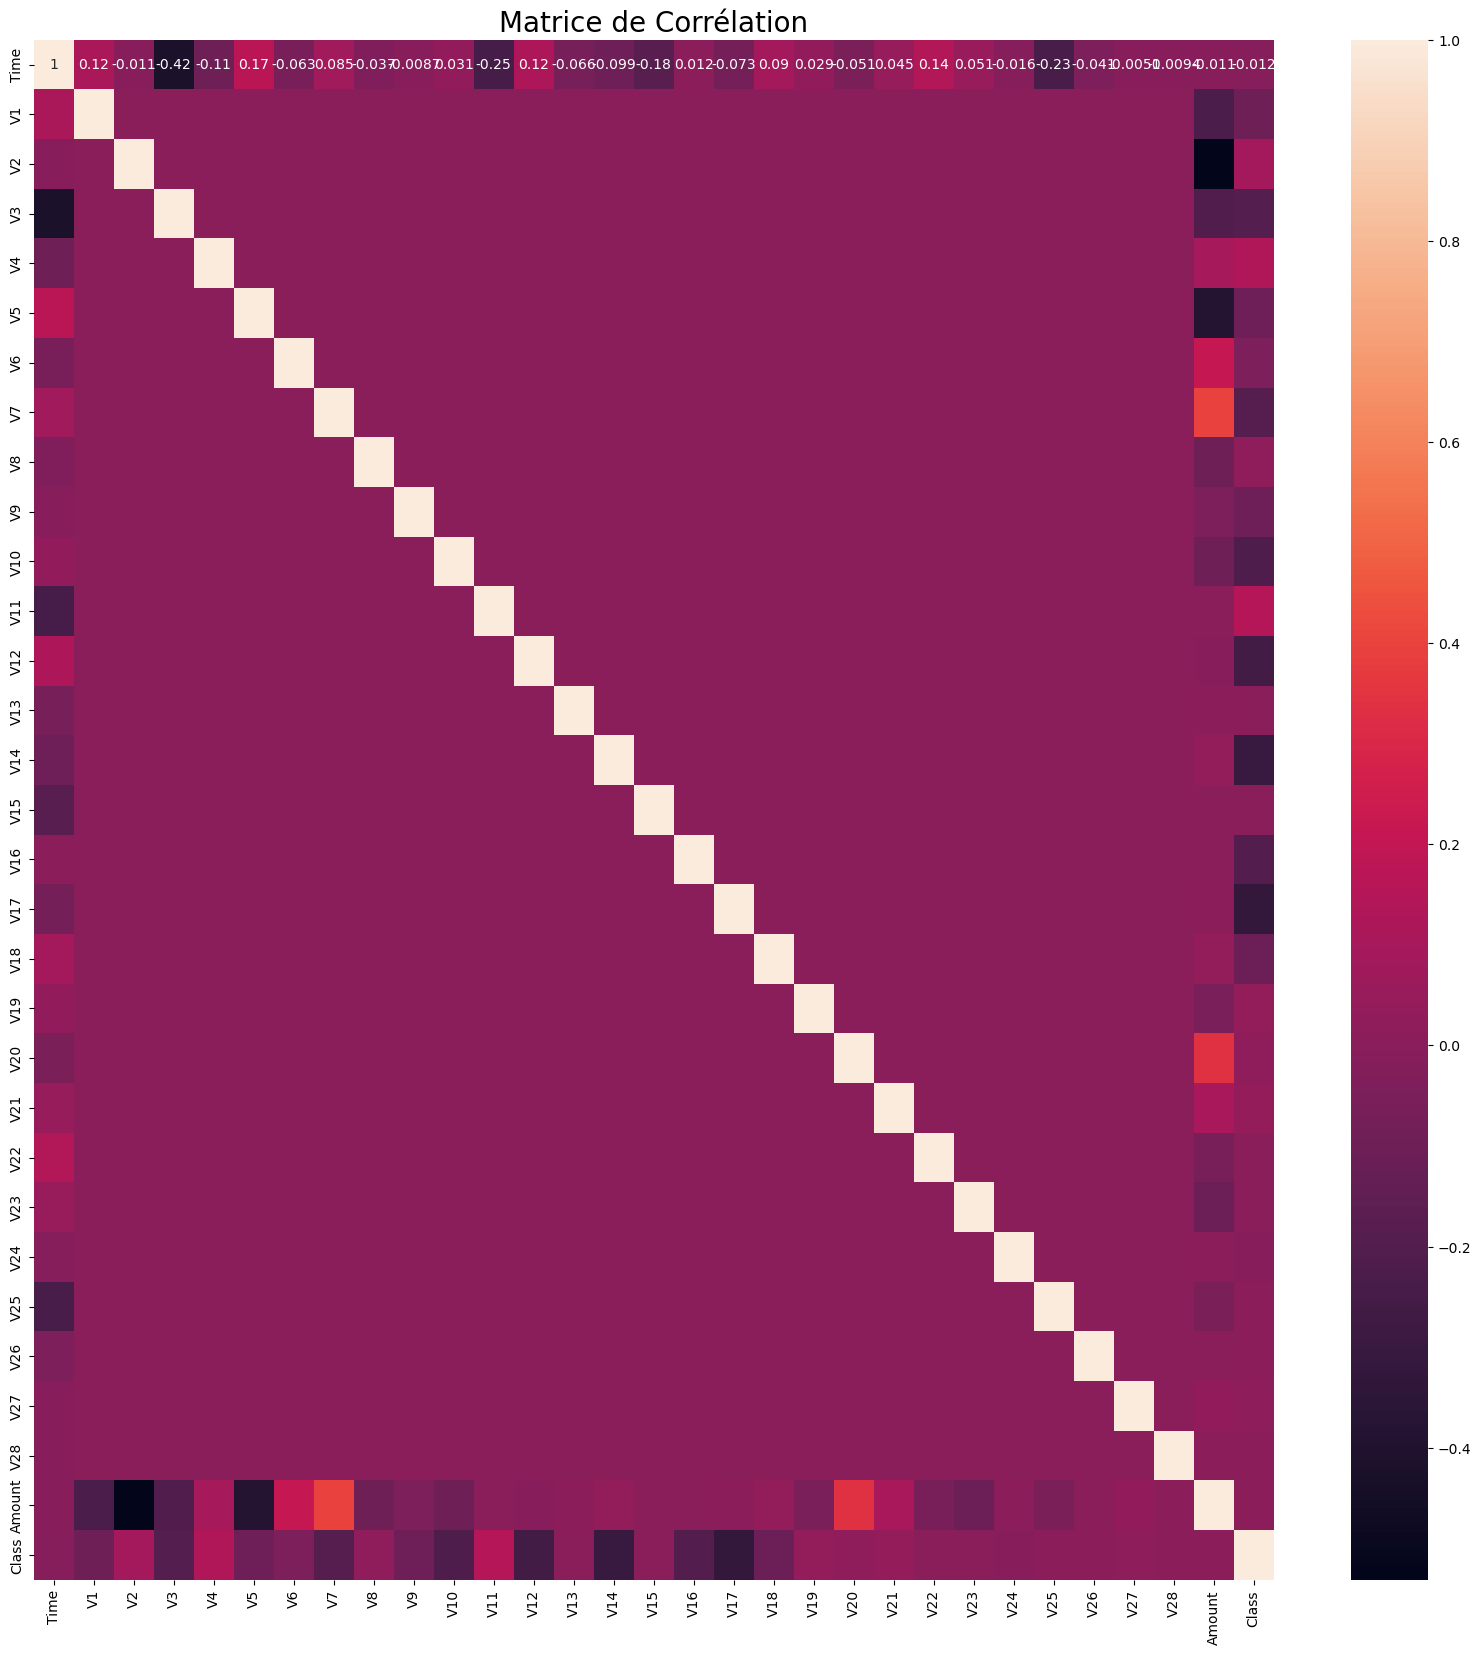

In [19]:
plt.figure(figsize=(20,20))
df_corr = df.corr()
sns.heatmap(df_corr,annot=True)
#Ajouter un titre à la carte thermique
plt.title('Matrice de Corrélation', size=20)


In [20]:
# Créez des données d'entraînement et de test dans un rapport de 70:30
X = df.drop(labels='Class', axis=1) # Features
y = df.loc[:,'Class']               # Target Variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

### Comment allons nous équilibrer la fraude et les transactions légitimes en matière de données ?

In [21]:
# Équilibrage des Données
#Utilisation du suréchantillonnage des minorités synthétiques (SMOTE).
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [22]:
from sklearn.feature_selection import mutual_info_classif
mutual_infos = pd.Series(data=mutual_info_classif(X_res, y_res, discrete_features=False, random_state=1), index=X_train.columns)

In [23]:
mutual_infos.sort_values(ascending=False)

V14       0.535044
V10       0.464775
V12       0.456052
V17       0.438193
V4        0.427427
V11       0.404040
Amount    0.392909
V3        0.387187
V16       0.335317
V7        0.304171
V2        0.291484
V9        0.256678
Time      0.247989
V21       0.235010
V27       0.229914
V1        0.220736
V18       0.198262
V8        0.174371
V6        0.171973
V28       0.170495
V5        0.157362
V20       0.107488
V19       0.099836
V23       0.067332
V24       0.063567
V26       0.046974
V25       0.031606
V22       0.031539
V13       0.024931
V15       0.022442
dtype: float64

<Axes: ylabel='count'>

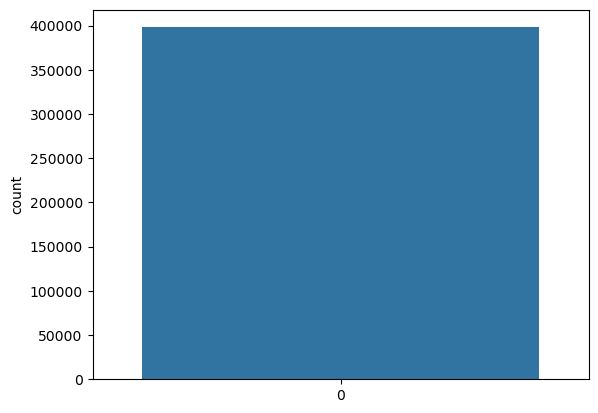

In [24]:
sns.countplot(y_res)

Par conséquent, nous pouvons dire que les fonctionnalités les plus corrélées après avoir résolu le déséquilibre des classes à l’aide du suréchantillonnage des minorités synthétiques sont V14, V10, V4, V12 et V17.

### Évaluation des Modèles
Utilisation des scores AUC-ROC, rapport de classification, précision et score F1 pour évaluer les performances.s.

In [25]:
# Évaluation des classificateurs
def grid_eval(grid_clf):
    """
        Méthode pour calculer le meilleur score et les meilleurs paramètres trouvés par la recherche en grille (grid search).
        Paramètre:
            grid_clf: Le classificateur avec recherche en grille (Grid Search Classifier)
    """
    print("Meilleur score", grid_clf.best_score_)
    print("Meilleur paramètre", grid_clf.best_params_)
    
def evaluation(y_test, grid_clf, X_test):
    """
        Méthode pour calculer les éléments suivants :
            1. Rapport de classification
            2. F1-score
            3. Score AUC-ROC
            4. Précision (Accuracy)
        Paramètres:
            y_test: Le jeu de données de test de la variable cible
            grid_clf: Le classificateur sélectionné avec recherche en grille
            X_test: Le jeu de données de test des caractéristiques d'entrée
    """
    y_pred = grid_clf.predict(X_test)
    print('RAPPORT DE CLASSIFICATION')
    print(classification_report(y_test, y_pred))
    
    print('AUC-ROC')
    print(roc_auc_score(y_test, y_pred))
      
    print('F1-Score')
    print(f1_score(y_test, y_pred))
    
    print('Précision (Accuracy)')
    print(accuracy_score(y_test, y_pred))


In [26]:
# Les paramètres de chaque classificateur sont différents
# Par conséquent, nous n'utilisons pas une seule méthode et cela ne viole pas les principes DRY
# Nous définissons des pipelines pour chaque classificateur uniques avec des paramètres
param_grid_sgd = [{
    'model__loss': ['log'],
    'model__penalty': ['l1', 'l2'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20)
}, {
    'model__loss': ['hinge'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20),
    'model__class_weight': [None, 'balanced']
}]

pipeline_sgd = Pipeline([
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

MCC_scorer = make_scorer(matthews_corrcoef)
grid_sgd = GridSearchCV(estimator=pipeline_sgd, param_grid=param_grid_sgd, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)


grid_sgd.fit(X_res, y_res)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid=[{'model__alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00,...
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                          'model__class_weight': [None, 'balanced'],
                          'model__loss': ['hinge']}],
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [27]:
grid_eval(grid_sgd)

Meilleur score 0.9560162686072134
Meilleur paramètre {'model__alpha': 0.001, 'model__loss': 'log', 'model__penalty': 'l1'}


In [28]:
evaluation(y_test, grid_sgd, X_test)

RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.14      0.91      0.25       148

    accuracy                           0.99     85443
   macro avg       0.57      0.95      0.62     85443
weighted avg       1.00      0.99      0.99     85443

AUC-ROC
0.9479720619851928
F1-Score
0.2460973370064279
Précision (Accuracy)
0.990391254988706


In [29]:
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])
param_grid_rf = {'model__n_estimators': [75]}
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_rf.fit(X_res, y_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=-1, param_grid={'model__n_estimators': [75]},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [30]:
grid_eval(grid_rf)

Meilleur score 0.9997538267139271
Meilleur paramètre {'model__n_estimators': 75}


In [31]:
evaluation(y_test, grid_rf, X_test)

RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      0.22      0.36       148

    accuracy                           1.00     85443
   macro avg       1.00      0.61      0.68     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC
0.6114864864864865
F1-Score
0.3646408839779005
Précision (Accuracy)
0.9986540734758845


In [32]:
pipeline_lr = Pipeline([
    ('model', LogisticRegression(random_state=1))
])
param_grid_lr = {'model__penalty': ['l2'],
                 'model__class_weight': [None, 'balanced']}
grid_lr = GridSearchCV(estimator=pipeline_lr, param_grid=param_grid_lr, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_lr.fit(X_res, y_res)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced'],
                         'model__penalty': ['l2']},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [33]:
grid_eval(grid_lr)

Meilleur score 0.9345423247997129
Meilleur paramètre {'model__class_weight': None, 'model__penalty': 'l2'}


In [34]:
evaluation(y_test, grid_lr, X_test)

RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.82      0.85       148

    accuracy                           1.00     85443
   macro avg       0.94      0.91      0.92     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC
0.9086899916505989
F1-Score
0.8491228070175438
Précision (Accuracy)
0.9994967405170698


In [35]:
pipeline_knn = Pipeline([
    ('model', KNeighborsClassifier(n_neighbors=5))
])
param_grid_knn = {'model__p': [2]}
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_knn.fit(X_res, y_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'model__p': [2]},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [36]:
grid_eval(grid_knn)

Meilleur score 0.9025783164998465
Meilleur paramètre {'model__p': 2}


In [37]:
evaluation(y_test, grid_knn, X_test)

RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC
0.5
F1-Score
0.0
Précision (Accuracy)
0.9982678510820079


### Conclusion
- Le classificateur K-Nearest Neighbours optimisé avec Grid Search, le meilleur paramètre étant la distance euclidienne (p = 2) surpasse ses homologues pour donner une précision de test de près de 99,8 % et un score F1 parfait avec un surajustement minimal.
- SMOTE surmonte le surapprentissage en suréchantillonnant synthétiquement les étiquettes de classe minoritaire et réussit dans une large mesure

### Résumé
- Toutes les transactions frauduleuses se produisent pour un montant inférieur à 2 500. Ainsi, la banque peut en déduire clairement que les auteurs de la fraude tentent de commettre des fraudes de montants inférieurs pour éviter les soupçons.
- Les transactions frauduleuses sont équitablement réparties dans le temps et il n'y a pas de relation claire entre le temps et la commission de la fraude.
- Le nombre de transactions frauduleuses est très faible par rapport aux transactions légitimes et doit être équilibré pour permettre une comparaison équitable et éviter un surajustement du modèle.